**Setting up the notebook with all dependencies**

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import torch
import torch.nn as nn
import numpy as np
from random import uniform

**Defining the Neural Network architechture**

In [ ]:
#NeuralNetwork class is used to define the model architechture, forward pass

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 20)
        self.fc5 = nn.Linear(20, 20)
        self.fc6 = nn.Linear(20, 20)
        self.fc7 = nn.Linear(20, 20)
        self.fc8 = nn.Linear(20, 20)
        self.fc9 = nn.Linear(20, 20)
        self.fc10 = nn.Linear(20, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        x = self.tanh(self.fc5(x))
        x = self.tanh(self.fc6(x))
        x = self.tanh(self.fc7(x))
        x = self.tanh(self.fc8(x))
        x = self.tanh(self.fc9(x))
        x = self.fc10(x)
        return x

**Encapsulating the funcionalities of PINN inside a PhysicsInformedNN class**

In [ ]:
#Defining the Physics Informed Neural Network

class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f):
        # x & t from boundary conditions:
        self.x_u = torch.tensor(X_u[:, 0].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)
        self.t_u = torch.tensor(X_u[:, 1].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)

        # x & t from collocation points:
        self.x_f = torch.tensor(X_f[:, 0].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)
        self.t_f = torch.tensor(X_f[:, 1].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)

        # boundary solution:
        self.u = torch.tensor(u, dtype=torch.float32)

        # null vector to test against f:
        self.null = torch.zeros((self.x_f.shape[0], 1))

        # initialize net:
        self.net = NeuralNetwork()

        # this optimizer updates the weights and biases of the net:
        self.optimizer = torch.optim.LBFGS(self.net.parameters(),
                                           lr=1,
                                           max_iter=50000,
                                           max_eval=50000,
                                           history_size=50,
                                           tolerance_grad=1e-06,
                                           tolerance_change=0.5 * np.finfo(float).eps,
                                           line_search_fn="strong_wolfe")

        # typical MSE loss (this is a function):
        self.loss = nn.MSELoss()

        # loss :
        self.ls = 0

        # iteration number:
        self.iter = 0

    def net_u(self, x, t):
        u = self.net(torch.cat((x, t), dim=1))
        return u
        #The neural network will learn the function u basically

    def net_f(self, x, t):
        u = self.net_u(x, t)

        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]

        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]

        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True)[0]

        nu = 0.01 / np.pi  # constant in the diff. equation
        f = u_t + (u * u_x) - (nu * u_xx)

        return f
        #Calculating f function with the help of u and derivatives of u

    def plot(self):
        """ plot the solution on new data """

        x = torch.linspace(-1, 1, 200)
        t = torch.linspace(0, 1, 100)

        # x & t grids:
        X, T = torch.meshgrid(x, t)

        # x & t columns:
        xcol = X.reshape(-1, 1)
        tcol = T.reshape(-1, 1)

        # one large column:
        usol = self.net_u(xcol, tcol)

        # reshape solution:
        U = usol.reshape(x.numel(), t.numel())

        # transform to numpy:
        xnp = x.numpy()
        tnp = t.numpy()
        Unp = U.detach().numpy()

        # plot:
        fig = plt.figure(figsize=(9, 4.5))
        ax = fig.add_subplot(111)

        h = ax.imshow(Unp,
                      interpolation='nearest',
                      cmap='rainbow',
                      extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()],
                      origin='lower', aspect='auto')

        plt.xlabel('t')
        plt.ylabel('x')
        plt.title('u(x,t)', fontsize = 10)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.10)
        cbar = fig.colorbar(h, cax=cax)
        cbar.ax.tick_params(labelsize=10)
        plt.show()

    def closure(self):
        # reset gradients to zero:
        self.optimizer.zero_grad()

        # u & f predictions:
        u_prediction = self.net_u(self.x_u, self.t_u)
        f_prediction = self.net_f(self.x_f, self.t_f)

        # losses:
        u_loss = self.loss(u_prediction, self.u)
        f_loss = self.loss(f_prediction, self.null)
        self.ls = u_loss + f_loss

        # derivative with respect to net's weights:
        self.ls.backward()

        # increase iteration count:
        self.iter += 1

        # print report:
        if not self.iter % 100:
            print('Epoch: {0:}, Loss: {1:6.9f}'.format(self.iter, self.ls))

        return self.ls

    def train(self):
        """ training loop """
        self.net.train()
        self.optimizer.step(self.closure)

**Generating training data**

In [ ]:
#Defining a function to generate the training points
#When we say training data, We just mean sampled points
#For both boundary conditions and collocation points

def generate_data():

    N_u = 100  # number of data points in the boundaries
    N_f = 10000  # number of collocation points

    # X_u_train: a set of pairs (x, t) located at:
    # x =  1, t = [0,  1]
    # x = -1, t = [0,  1]
    # t =  0, x = [-1, 1]

    #For boundary points
    #Defining the helper variables in sampling the training boundary points

    x_upper = np.ones((N_u // 4, 1), dtype=float)
    x_lower = np.ones((N_u // 4, 1), dtype=float) * (-1)
    t_zero = np.zeros((N_u // 2, 1), dtype=float)

    #Sampling random numbers between 0 and 1

    t_upper = np.random.rand(N_u // 4, 1)
    t_lower = np.random.rand(N_u // 4, 1)
    x_zero = (-1) + np.random.rand(N_u // 2, 1) * (1 - (-1))

    #Combining different xs and ts

    X_upper = np.hstack((x_upper, t_upper)) #x= +1 , t=[0,1]
    X_lower = np.hstack((x_lower, t_lower)) #x= -1 , t=[0,1]
    X_zero = np.hstack((x_zero, t_zero))    #x[-1,1], t=0

    #Combining them vertically, We get X_u_train which represents training data for boundary points

    X_u_train = np.vstack((X_upper, X_lower, X_zero))

    #Shuffling X_u_train:

    index = np.arange(0, N_u)
    np.random.shuffle(index)
    X_u_train = X_u_train[index, :]

    #Making X_f_train
    #For collocation points
    #Defining the helper variables in sampling the training collocation points
    X_f_train = np.zeros((N_f, 2), dtype=float)
    for row in range(N_f):

        x = uniform(-1, 1)  # x range
        t = uniform(0, 1)  # t range

        #Basically x=[-1,1] , t=[0,1]

        X_f_train[row, 0] = x
        X_f_train[row, 1] = t

    #Now, What if we just combined boundary points and collocation points and getting the whole training points(data) ready
    # add the boundary points to the collocation points:
    X_f_train = np.vstack((X_f_train, X_u_train))

    #Making training data for u(0, x) = -sin(pie * x)
    #Calling it U_train data

    u_upper = np.zeros((N_u // 4, 1), dtype=float)
    u_lower = np.zeros((N_u // 4, 1), dtype=float)
    u_zero = -np.sin(np.pi * x_zero)

    #Stacking them in the same order as X_u_train
    u_train = np.vstack((u_upper, u_lower, u_zero))

    #Matching the index with X_u_train
    u_train = u_train[index, :]

    return(X_u_train, u_train, X_f_train)

In [ ]:
#Calling the function to generate the training points

X_u_train, u_train, X_f_train=generate_data()

**Training the network**

In [ ]:
#Putting it all together and then training the model:

pinn = PhysicsInformedNN(X_u_train, u_train, X_f_train)

pinn.train()

Epoch: 100, Loss: 0.201396972
Epoch: 200, Loss: 0.054133855
Epoch: 300, Loss: 0.029702269
Epoch: 400, Loss: 0.018336952
Epoch: 500, Loss: 0.013318390
Epoch: 600, Loss: 0.011347713
Epoch: 700, Loss: 0.013281081
Epoch: 800, Loss: 0.007159049
Epoch: 900, Loss: 0.006021230
Epoch: 1000, Loss: 0.005074786
Epoch: 1100, Loss: 0.004621484
Epoch: 1200, Loss: 0.004013757
Epoch: 1300, Loss: 0.003600315
Epoch: 1400, Loss: 0.003130734
Epoch: 1500, Loss: 0.002857574
Epoch: 1600, Loss: 0.002571999
Epoch: 1700, Loss: 0.002262658
Epoch: 1800, Loss: 0.001972690
Epoch: 1900, Loss: 0.001740552
Epoch: 2000, Loss: 0.001551348
Epoch: 2100, Loss: 0.001333606
Epoch: 2200, Loss: 0.001168299
Epoch: 2300, Loss: 0.001050115
Epoch: 2400, Loss: 0.000944447
Epoch: 2500, Loss: 0.000851935
Epoch: 2600, Loss: 0.000788363
Epoch: 2700, Loss: 0.000697837
Epoch: 2800, Loss: 0.000621018
Epoch: 2900, Loss: 0.000566859
Epoch: 3000, Loss: 0.000498107
Epoch: 3100, Loss: 0.000457536
Epoch: 3200, Loss: 0.000407475
Epoch: 3300, Loss

**Plotting the result**

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


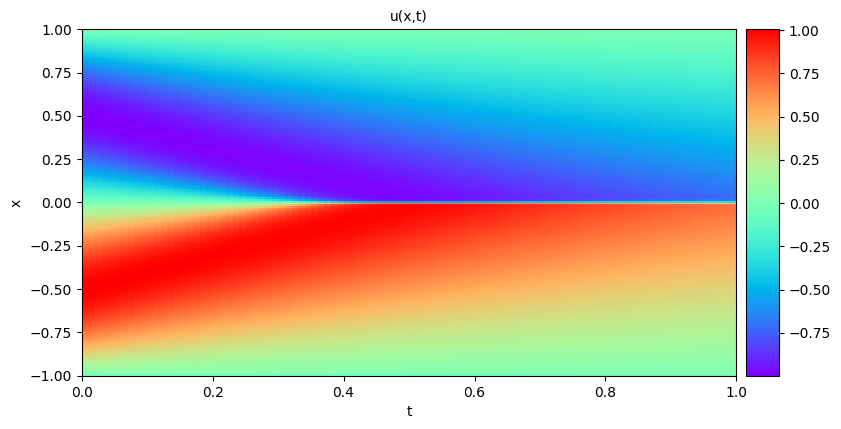

In [ ]:
#Plotting the result

pinn.plot()